# How does the number of synapses into/out of a neuron depend on the neuron's neurotransmitter

[Wang _et al._, 2024](https://doi.org/10.1101/2024.09.24.614724) found that the optimal functional complexity of the larval Drosophila network was achieved with a ~4:1 excitatory to inhibitory neuron ratio, but with the inhibitory neurons having higher numbers of inputs.

Do we see this in VNC?

In [ ]:
%reload_ext autoreload
%autoreload 2

import polars as pl
from plotnine import *

from vnc_networks.connections import Connections
from vnc_networks.connectome_reader import MANC


In [7]:
CR = MANC("v1.2.3")
connections = Connections(CR=CR)  # entire datasets

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


Attribute class_1 not found in the graph. Adding it.


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


In [14]:
details = CR.load_data_neuron_set(
    connections.get_neuron_bodyids(),
    [
        "nt_type",
        "nb_pre_neurons",
        "nb_post_neurons",
		"class_1",
    ],
)
details

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


nt_type,nb_pre_neurons,nb_post_neurons,class_1,body_id
str,i64,i64,str,i64
"""acetylcholine""",2002,4318,"""descending neuron""",10000
"""glutamate""",55,554,"""sensory neuron""",10001
"""acetylcholine""",1902,3826,"""descending neuron""",10002
"""acetylcholine""",122,1307,"""sensory neuron""",10003
"""gaba""",1567,3052,"""intrinsic neuron""",10004
…,…,…,…,…
"""acetylcholine""",45,1265,"""descending neuron""",53595462076
"""acetylcholine""",70,557,"""sensory ascending""",53606232860
"""glutamate""",62,235,"""sensory ascending""",53609615822


In [15]:
details["nt_type"].value_counts()


nt_type,count
str,u32
"""unclear""",29
"""gaba""",5727
"""unknown""",50
"""glutamate""",6218
"""acetylcholine""",11519


Here we don't see the 4:1 ratio - there are 11675 excitatory neurons (acetylcholine) and 7268 inhibitory neurons (gaba) so it's more like 2:1. We ignore all the glutamate neurons, and the unknown ones.

I'm not sure why there are 340K neurons with None as the neurotransmitter, so I remove them...

In [16]:
details["nt_type", "nb_pre_neurons", "nb_post_neurons"].group_by(
    "nt_type"
).mean()


nt_type,nb_pre_neurons,nb_post_neurons
str,f64,f64
"""glutamate""",1194.421357,1812.296237
"""gaba""",1914.911297,3384.545137
"""unclear""",1321.586207,0.0
"""unknown""",2658.1,60.16
"""acetylcholine""",1315.898429,3075.120323


We do see a higher mean in-degree for gaba synapses than acetylcholine, whereas the out-degrees are fairly similar. Let's check the full distributions.

/home/dallosto/micromamba/envs/vnc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/dallosto/micromamba/envs/vnc/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 29 rows containing non-finite values.


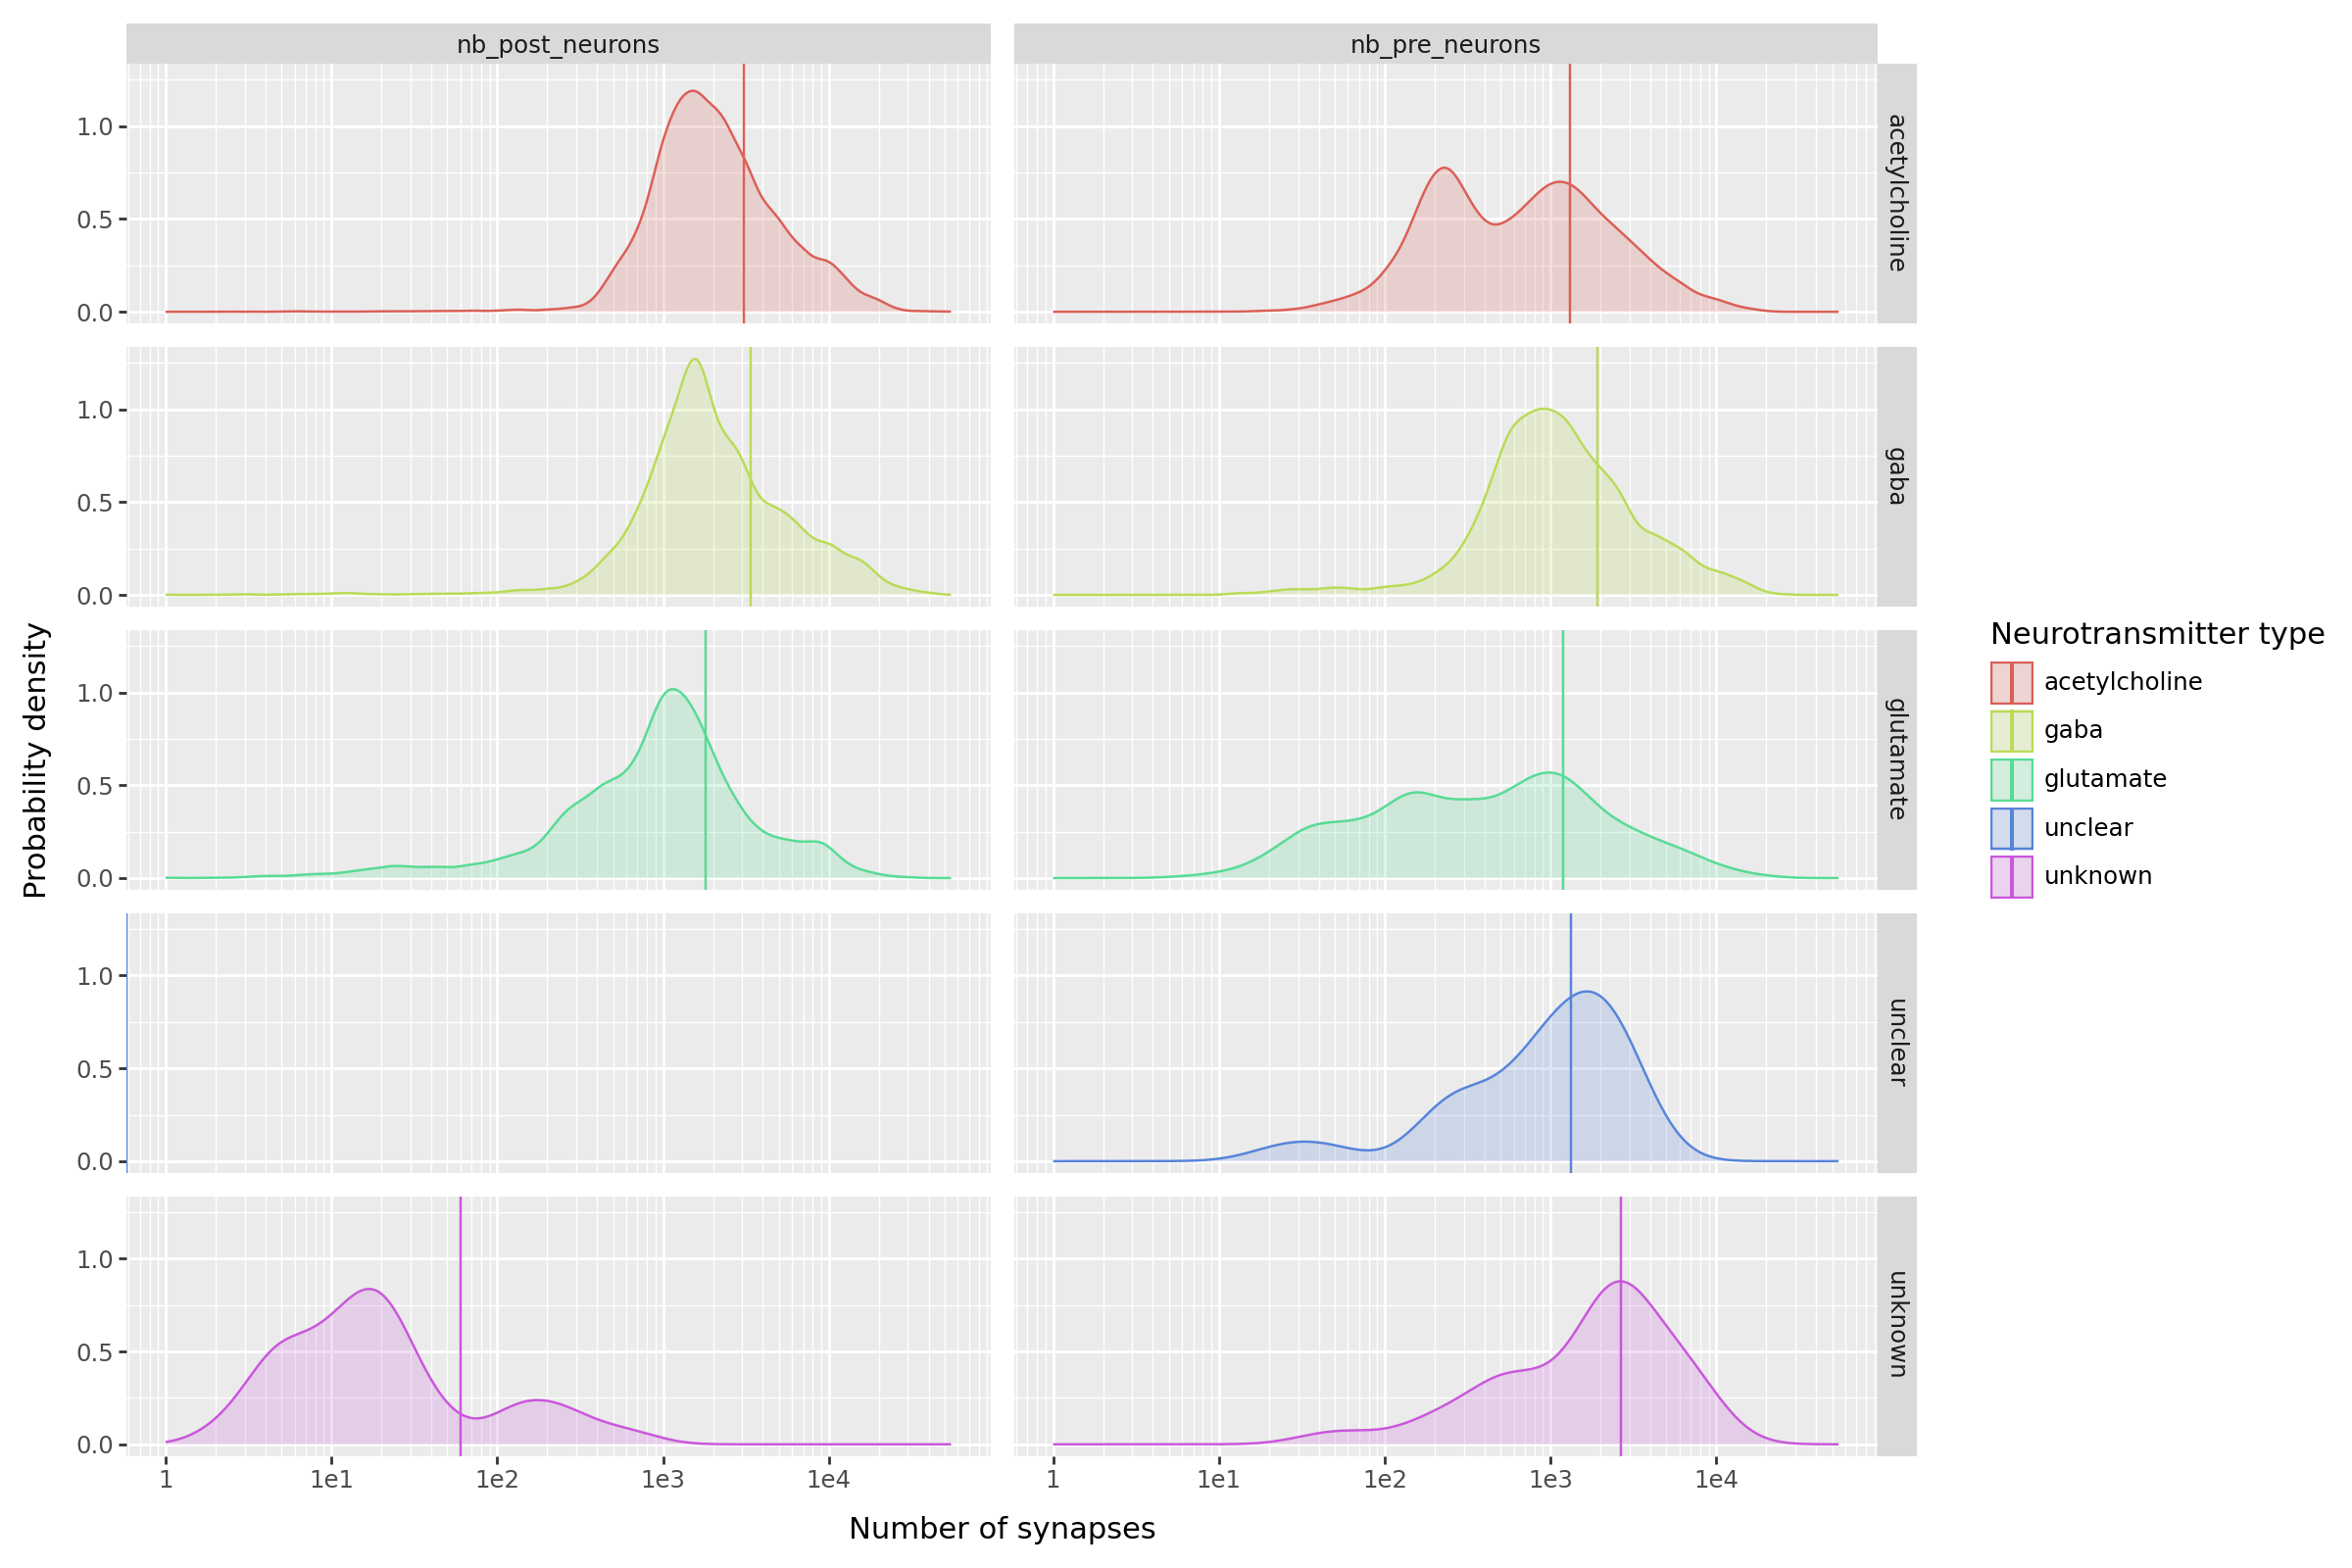

In [18]:
(
    ggplot(
        details.unpivot(index="nt_type", on=["nb_pre_neurons", "nb_post_neurons"]),
        aes(
            x="value",
            color="nt_type",
            fill="nt_type",
        ),
    )
    + facet_grid(rows="nt_type", cols="variable")
    + geom_density(alpha=0.2)
    + geom_vline(
        aes(xintercept="value", color="nt_type"),
        details["nt_type", "nb_pre_neurons", "nb_post_neurons"]
        .group_by("nt_type")
        .mean()
        .unpivot(index="nt_type"),
    )
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neurotransmitter type",
        fill="Neurotransmitter type",
    )
    + theme(figure_size=(12, 8))
)


So while the mean of the gaba in degree is higher, it looks to be because the acetylcholine in degree distribution is bimodal

We can see it more clearly if we overlay the distributions

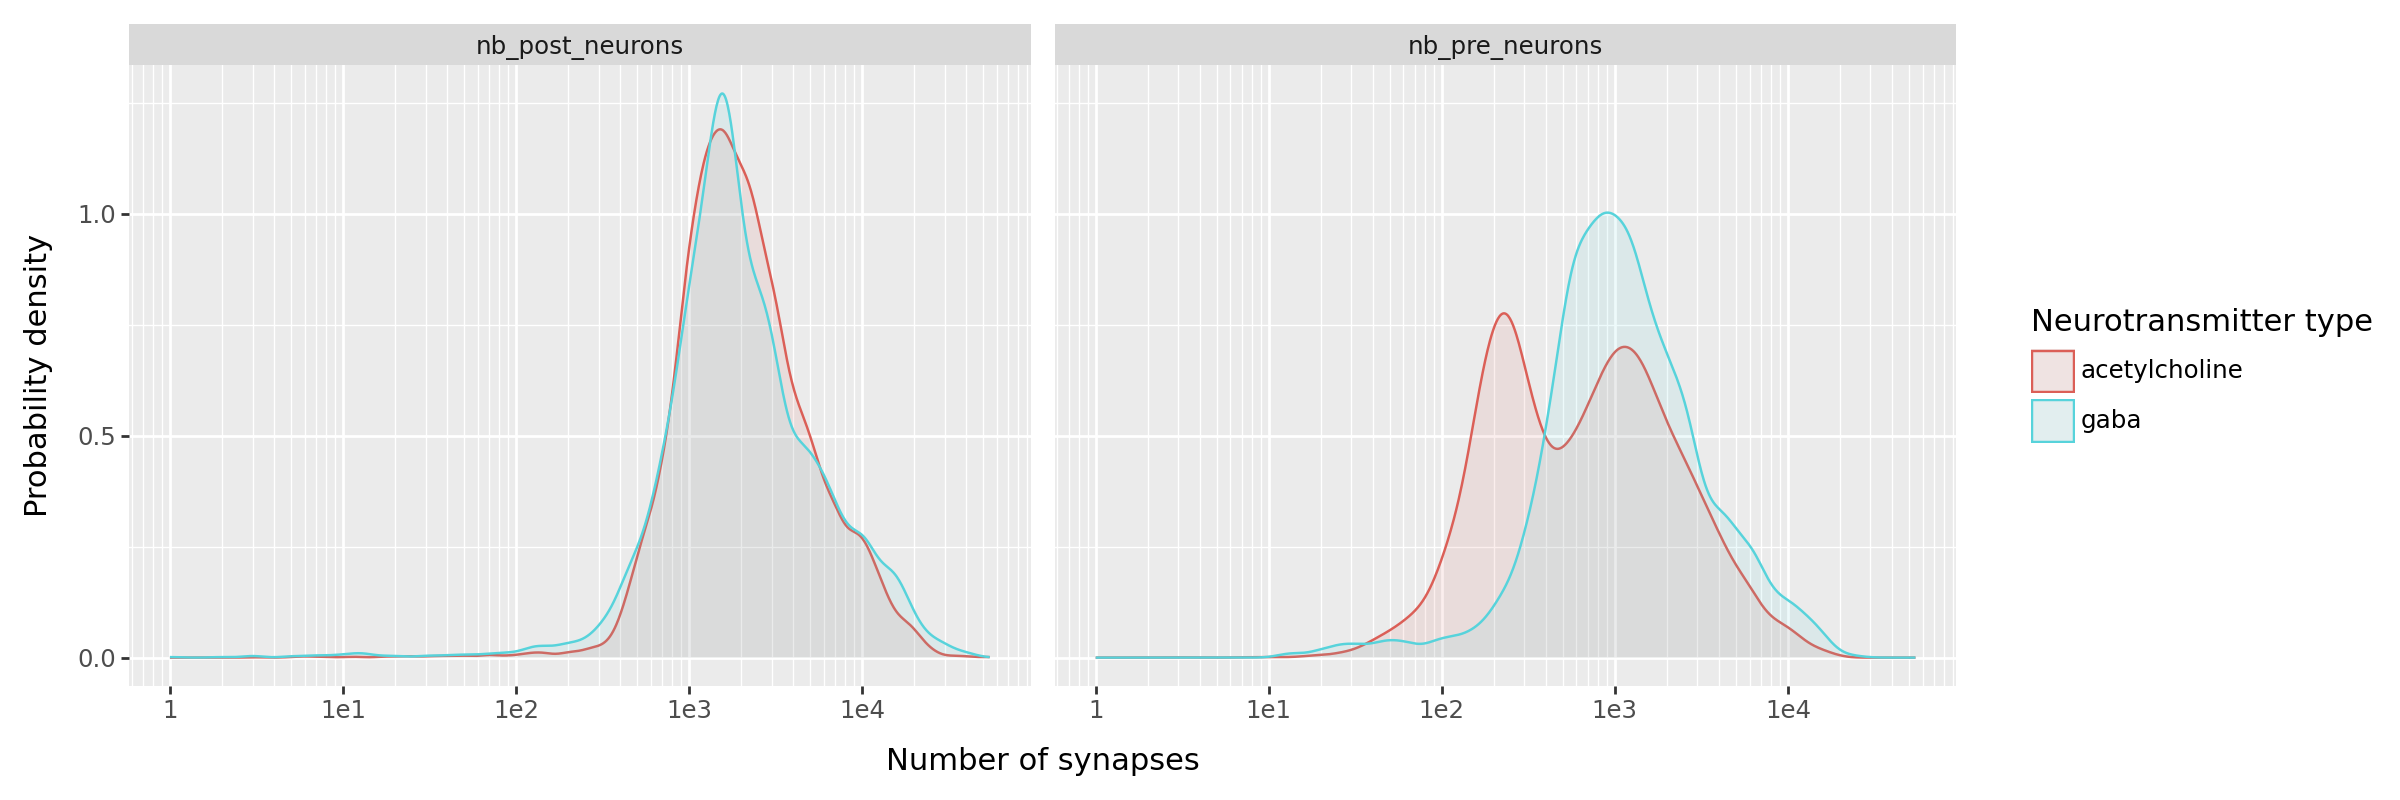

In [21]:
(
    ggplot(
        details.filter(pl.col("nt_type").is_in(["acetylcholine", "gaba"])).unpivot(
            index="nt_type", on=["nb_pre_neurons", "nb_post_neurons"]
        ),
        aes(
            x="value",
            color="nt_type",
            fill="nt_type",
        ),
    )
    + facet_wrap("variable")
    + geom_density(alpha=0.1)
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neurotransmitter type",
        fill="Neurotransmitter type",
    )
    + theme(figure_size=(12, 4))
)


Where does this bimodal distribution come from? Let's break down the in degree distributions based on neuron class. Maybe that plays a role?

In [22]:
classes_of_acetylcholine_neurons = details.filter(~pl.col("class_1").is_null(), nt_type="acetylcholine")["class_1"].value_counts()

classes_of_acetylcholine_neurons

class_1,count
str,u32
"""efferent neuron""",6
"""sensory neuron""",3500
"""descending neuron""",931
"""motor neuron""",32
"""sensory ascending""",477
"""Interneuron TBD""",3
"""intrinsic neuron""",5329
"""sensory descending""",6
"""ascending neuron""",1232


In [30]:
most_import_neuron_classes = classes_of_acetylcholine_neurons.filter(pl.col("count") > 10)["class_1"].to_list()

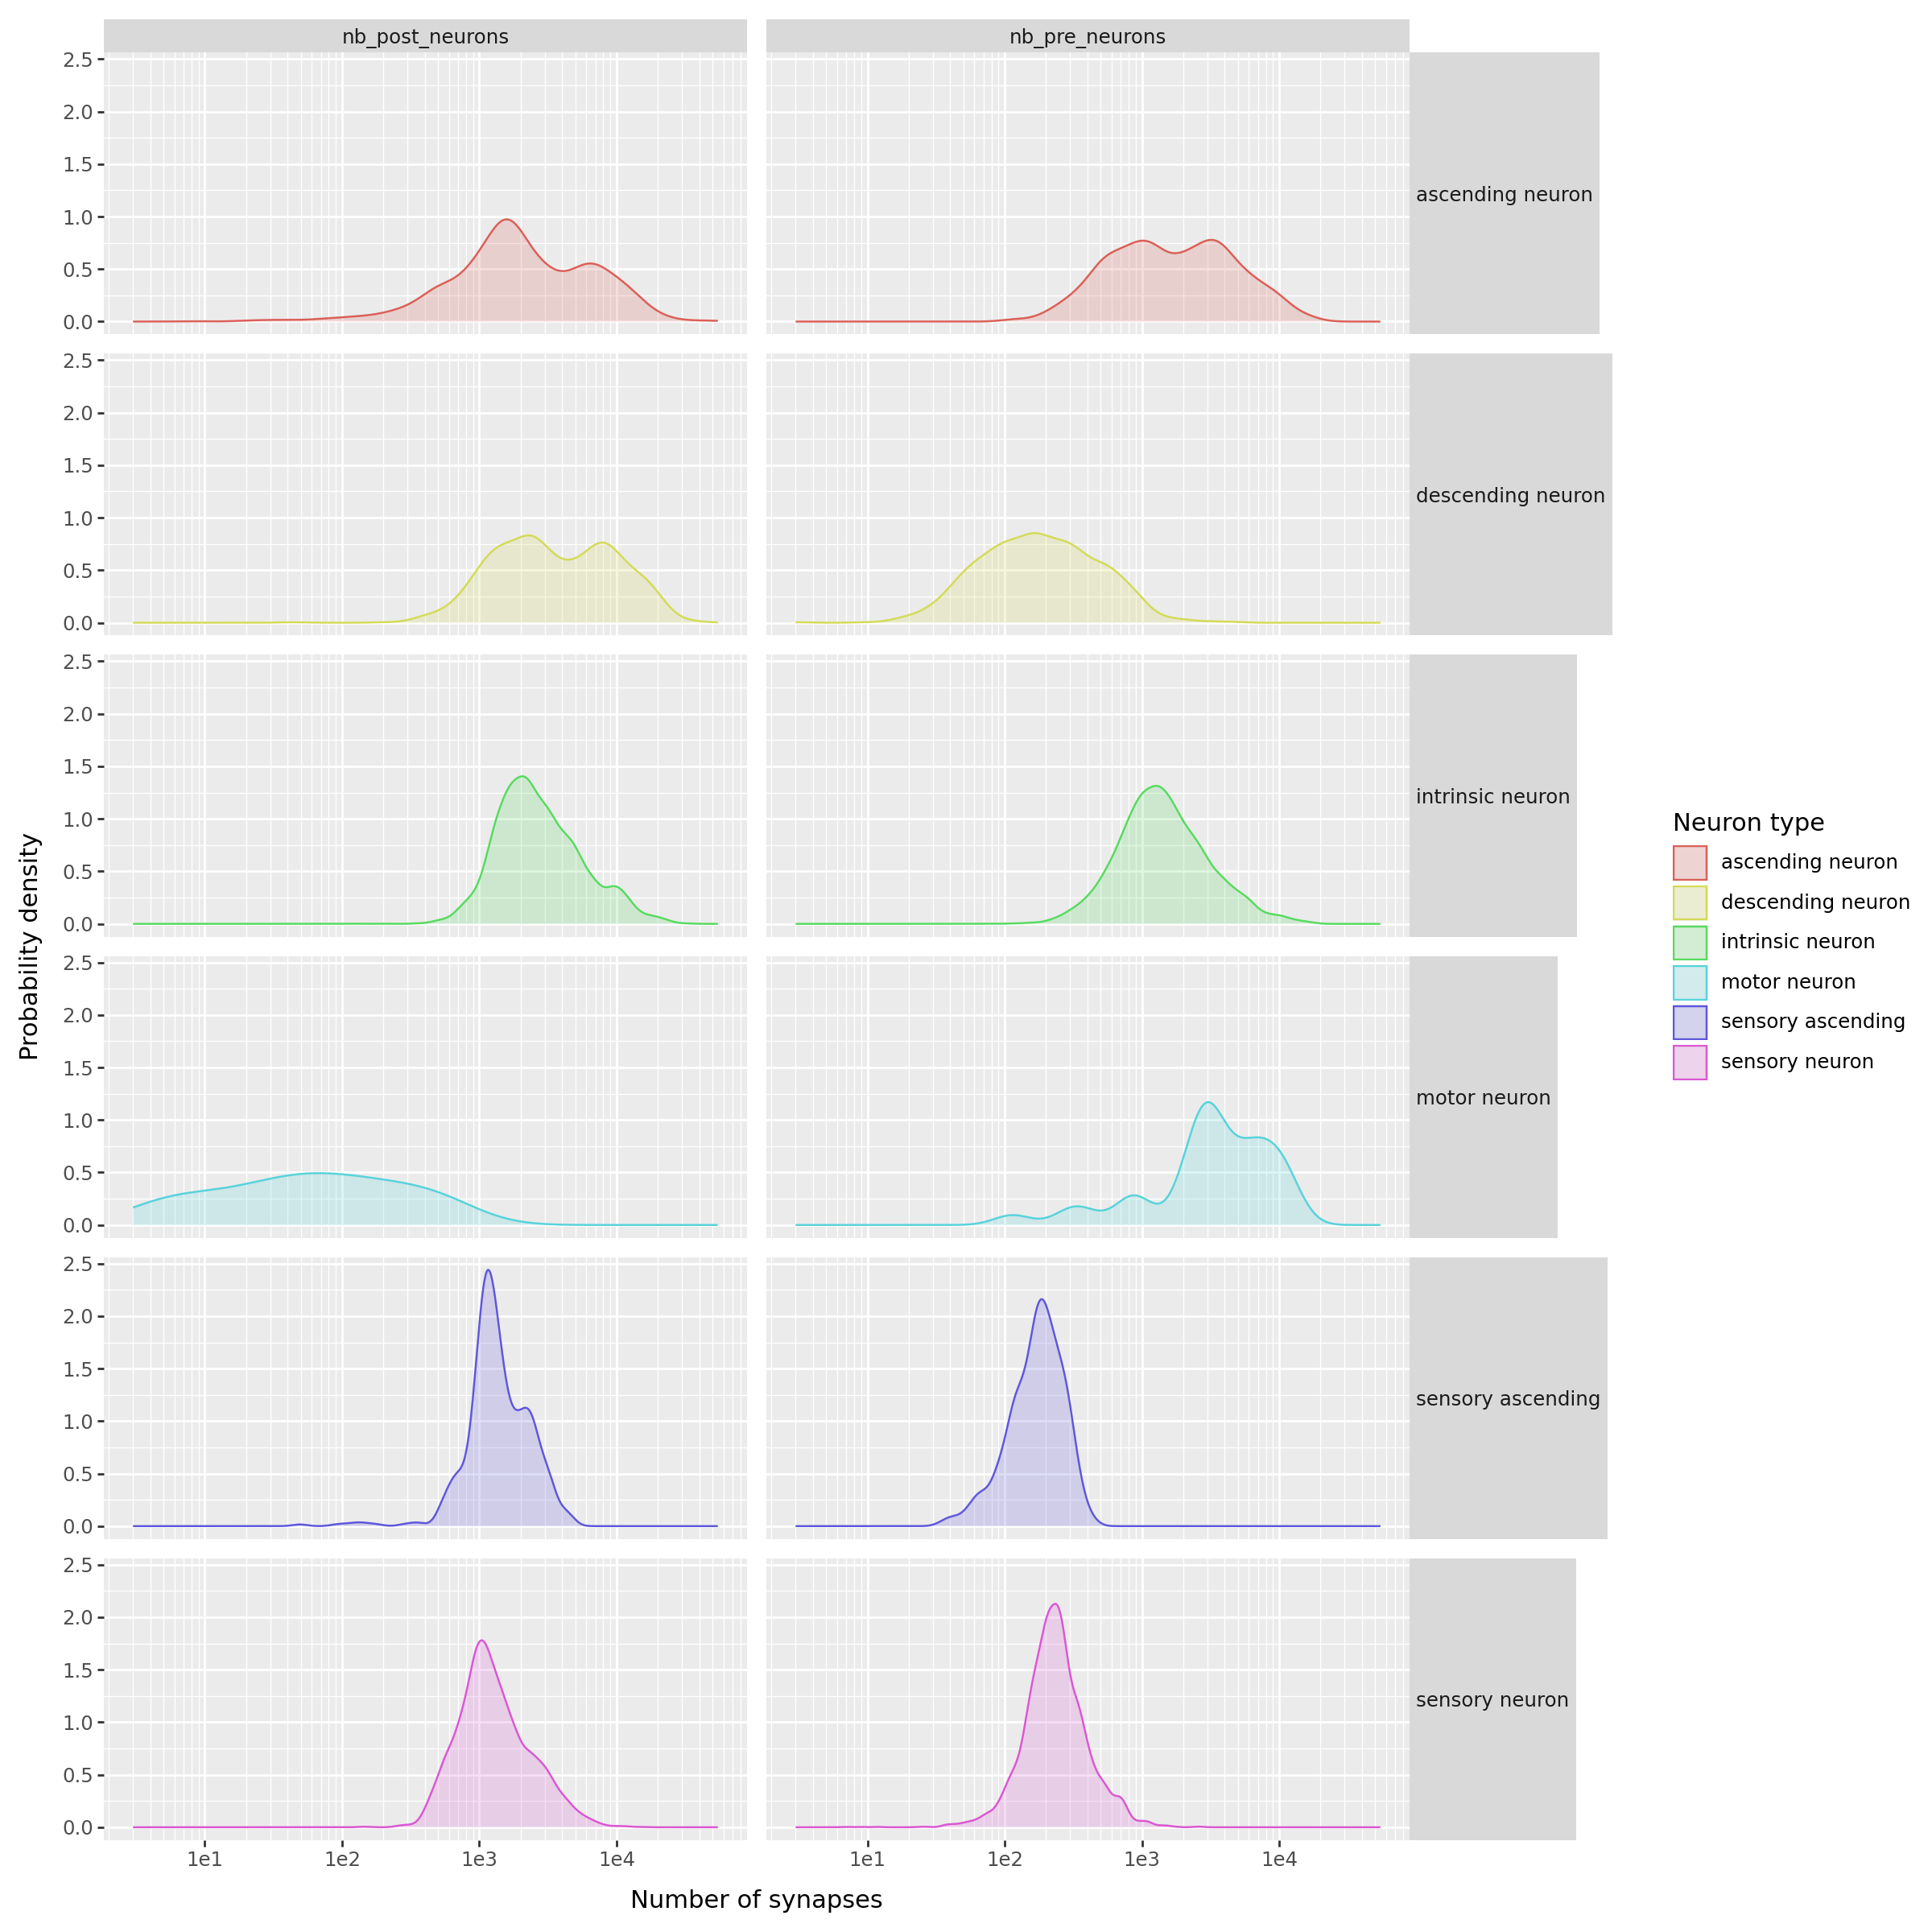

In [34]:
(
    ggplot(
        details.filter(pl.col("class_1").is_in(most_import_neuron_classes), nt_type="acetylcholine").unpivot(index="class_1", on=["nb_pre_neurons", "nb_post_neurons"]),
        aes(
            x="value",
            color="class_1",
            fill="class_1",
        ),
    )
    + facet_grid(rows="class_1", cols="variable")
    + geom_density(alpha=0.2)
    + scale_x_log10()
    + labs(
        y="Probability density",
        x="Number of synapses",
        color="Neuron type",
        fill="Neuron type",
    )
    + theme(figure_size=(12, 12), strip_text_y=element_text(angle=0))
)


Now we can see that the lower in-degree acetylcholine neurons are sensory and DNs, while the higher in-degree neurons are instrinic, ANs, and motor neurons. For ANs, DNs, and MNs, this makes sense. It's interesting that sensory neurons don't have a low number of inputs though...

We can also see that the number of incoming and outgoing synapses correlates well for each neuron type individually, but that they have different ranges for the number of incoming synapses

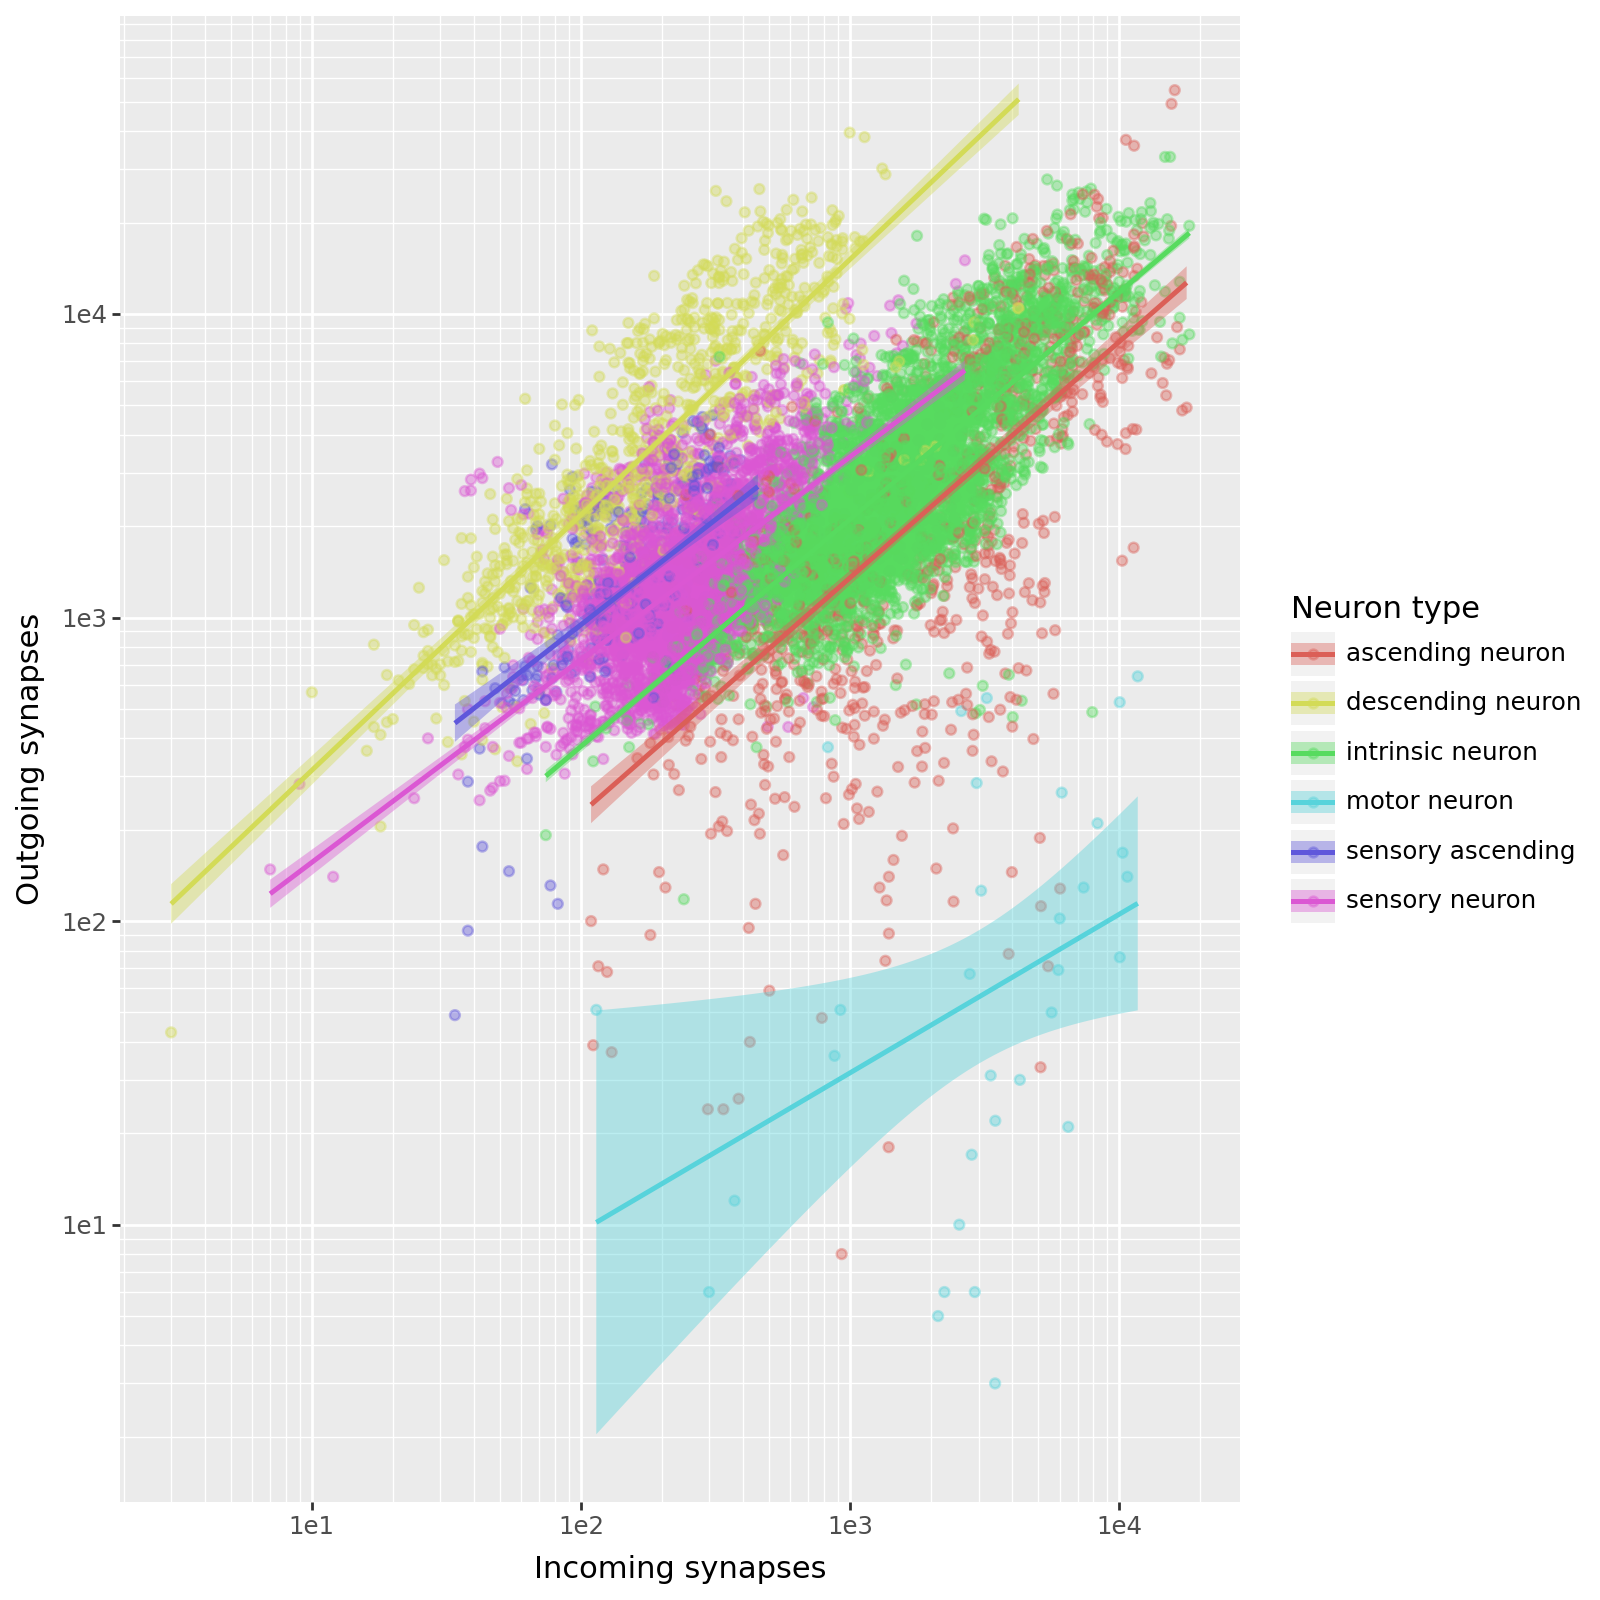

In [36]:
(
    ggplot(
        details.filter(pl.col("class_1").is_in(most_import_neuron_classes), nt_type="acetylcholine"),
        aes(
            x="nb_pre_neurons",
            y="nb_post_neurons",
            color="class_1",
            fill="class_1",
        ),
    )
    + geom_point(alpha=0.4)
	+ geom_smooth()
    + scale_x_log10()
    + scale_y_log10()
    + theme(figure_size=(8, 8))
	+ labs(
        x="Incoming synapses",
        y="Outgoing synapses",
        color="Neuron type",
        fill="Neuron type",
    )
)